# Código de solución
---
**Descripción del objetivo** 

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes con la finalidad de poder crear una estrategia de retención mediante descuentos y promociones.

Sus principales servicios son:
- Telefonía fija.
- Internet por línea telefónica o fibra óptica.

**Objetivo principal**: Crear un modelo predictivo de **clasificación** que arroje que clientes podrían cancelar sus servicios.  
(El cliente 'x' va a cancelar?, sí (1) o no (0)?)

## Preprocesamiento y análisis exploratorio de datos

### Parte 1

In [1]:
# Importar Pandas y Cargar datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


import lightgbm as lgb

In [2]:
# Cargar datasets
df_contract = pd.read_csv('final_provider/final_provider/contract.csv')
df_internet = pd.read_csv('final_provider/final_provider/internet.csv')
df_personal = pd.read_csv('final_provider/final_provider/personal.csv')
df_phone = pd.read_csv('final_provider/final_provider/phone.csv')

#### Examinación de datos

In [3]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [5]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [6]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


#### Estudio de datos

In [7]:
df_contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


In [8]:
df_internet.head(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


In [9]:
df_personal.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


In [10]:
df_personal['Dependents']

0        No
1        No
2        No
3        No
4        No
       ... 
7038    Yes
7039    Yes
7040    Yes
7041     No
7042     No
Name: Dependents, Length: 7043, dtype: object

In [11]:
df_phone.head(3)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


#### Unificación de datasets

In [12]:
df_merge = df_contract.merge(df_personal, on='customerID', how='left') \
    .merge(df_internet, on='customerID', how='left') \
    .merge(df_phone, on='customerID', how='left')

In [13]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [14]:
df_merge.sample(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
5714,6108-OQZDQ,2019-08-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,97.95,384.5,Female,0,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Yes
2289,4056-QHXHZ,2014-02-01,No,Two year,No,Mailed check,107.45,7576.7,Female,0,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Yes
299,6390-DSAZX,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,73.60,73.6,Female,0,No,Yes,Fiber optic,Yes,No,No,No,No,No,No


#### Limpieza y formateo de datos

In [15]:
# Función limpieza de datos
def columns_format(df):
    import re
    df_new = df.copy()

    new_cols = {}
    for col in df_new.columns:
        new_col = re.sub(r'([a-z])([A-Z])', r'\1_\2', col, count=1)
        new_cols[col] = new_col.lower().replace(' ', '_').replace('-', '_')
    resultado = df_new.rename(columns=new_cols)

    for col in resultado.columns:
        if col not in ['begin_date', 'end_date']:
            if resultado[col].dtype == 'object':
                resultado[col] = resultado[col].str.lower().str.replace(
                    ' ', '_').str.replace('-', '_')

    return resultado


# Aplicar función de limpieza
df_clean = columns_format(df_merge)
df_clean.sample(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
5252,2615_yvmyx,2014-03-01,No,month_to_month,yes,electronic_check,107.50,7713.55,male,1,yes,no,fiber_optic,yes,yes,yes,no,yes,yes,yes
761,1894_igfsg,2017-12-01,2019-10-01 00:00:00,month_to_month,no,electronic_check,89.25,1907.85,female,0,no,no,fiber_optic,no,no,no,no,yes,yes,no
6890,7470_dynoe,2015-09-01,No,one_year,yes,electronic_check,61.10,3357.9,male,0,no,no,dsl,no,no,yes,no,no,yes,no


In [16]:
# Agregamos columnas necesarias para el análisis

# Cambio de tipo de datos a datetime
df_clean['begin_date'] = pd.to_datetime(df_clean['begin_date'])

# Columna nueva 'cancelation' con valores de 'end_date'
df_clean['cancelation'] = df_clean['end_date']

# Cambiamos valores 'no' por fecha de descarga del dataset
df_clean['end_date'] = np.where(
    df_clean['end_date'] == 'No', '2020-02-01', df_clean['end_date'])
df_clean['end_date'] = pd.to_datetime(df_clean['end_date'])

# Columna agregada de lealtad
df_clean['loyalty_months'] = (
    (df_clean['end_date'] - df_clean['begin_date']).dt.days) // 30

#### Eliminar datos incongruentes o irrelevantes

In [17]:
# Eliminamos columnas innecesarias
df_clean = df_clean.drop('end_date', axis=1)

# Eliminamos filas con información irrelevante
df_clean = df_clean[df_clean['total_charges'] != '_']

In [18]:
# Reordenamos columnas
reorder = ['customer_id', 'begin_date', 'cancelation', 'loyalty_months', 'monthly_charges', 'total_charges',
           'payment_method', 'type', 'paperless_billing', 'gender', 'senior_citizen',
           'partner', 'dependents', 'internet_service', 'online_security', 'online_backup',
           'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

df_clean = df_clean[reorder]
df_clean.sample(3)

,customer_id,begin_date,cancelation,loyalty_months,monthly_charges,total_charges,payment_method,type,paperless_billing,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
783,4678_dvqeo,2019-10-01,2019-11-01 00:00:00,1,52.20,52.2,electronic_check,month_to_month,yes,female,...,no,no,dsl,no,no,no,yes,no,no,no
4949,3669_lvwzb,2019-08-01,2020-01-01 00:00:00,5,51.00,305.95,mailed_check,month_to_month,yes,male,...,no,no,dsl,no,yes,no,no,yes,yes,NaN
381,6905_niqin,2019-09-01,2019-10-01 00:00:00,1,50.65,50.65,mailed_check,month_to_month,no,male,...,no,no,dsl,no,yes,no,no,no,no,no


#### Tratamiento de filas duplicadas y valores ausentes

In [19]:
# Filas duplicadas
df_clean.duplicated().sum()

0

In [20]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   cancelation        7032 non-null   object        
 3   loyalty_months     7032 non-null   int64         
 4   monthly_charges    7032 non-null   float64       
 5   total_charges      7032 non-null   object        
 6   payment_method     7032 non-null   object        
 7   type               7032 non-null   object        
 8   paperless_billing  7032 non-null   object        
 9   gender             7032 non-null   object        
 10  senior_citizen     7032 non-null   int64         
 11  partner            7032 non-null   object        
 12  dependents         7032 non-null   object        
 13  internet_service   5512 non-null   object        
 14  online_s

In [21]:
# Valores ausentes
df_clean.isnull().sum()[df_clean.isnull().sum() > 0]

internet_service     1520
online_security      1520
online_backup        1520
device_protection    1520
tech_support         1520
streaming_tv         1520
streaming_movies     1520
multiple_lines        680
dtype: int64

Conclusión  
* Puede parecer que tenemos una gran cantidad de valores ausentes, pero realmente NO existe ninguno, se crearon porque fusionamos los 4 datasets diferentes, por eso la decisión de tratamiento será cambiar todos por 'no' o en el caso de 'internet_service' por 'no_internet_service'.

In [22]:
# Tratamiento
df_clean['internet_service'] = df_clean['internet_service'].fillna(
    'no_internet_service')
df_clean = df_clean.fillna('no')
df_clean.isnull().sum()[df_clean.isnull().sum() > 0]

Series([], dtype: int64)

#### Cambiar tipo de datos

In [23]:
# Creamos nuevo df para entrenamiento
df_final = df_clean.copy()

# Cambio de tipo de datos a enteros


def object_to_int(df, columns):
    """Convierte columnas a enteros y reemplaza
    'yes' por 1 y 'no' por 0, y 'male' por 1 y 'female' por 0."""

    df = df.copy()
    for col in columns:
        df[col] = df[col].replace({'yes': 1, 'no': 0})
        df[col] = df[col].replace({'male': 1, 'female': 0})
        df[col] = df[col].astype('int8')
    return df


columns_to_change = ['paperless_billing', 'gender', 'senior_citizen', 'partner',
                     'dependents', 'online_security', 'online_backup', 'device_protection',
                     'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

# Aplicar la función
df_final = object_to_int(df_final, columns_to_change)

# Cambio de datos a entero
df_final['cancelation'] = np.where(df_final['cancelation'] == 'No', 0, 1)

# Cambio de los valores de la columna 'type' para mayor claridad
df_final['type'] = df_final['type'].replace(
    {'month_to_month': 'monthly', 'one_year': 'yearly'})

# Cambio de tipo de datos a category
df_final['type'] = df_final['type'].astype('category')
df_final['payment_method'] = df_final['payment_method'].astype('category')
df_final['internet_service'] = df_final['internet_service'].astype('category')

# Cambio de tipo de datos a numérico
df_final['total_charges'] = pd.to_numeric(
    df_final['total_charges'], errors='coerce')

In [24]:
# Revisamos cambios
print(df_final.info())
df_final.sample(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   cancelation        7032 non-null   int32         
 3   loyalty_months     7032 non-null   int64         
 4   monthly_charges    7032 non-null   float64       
 5   total_charges      7032 non-null   float64       
 6   payment_method     7032 non-null   category      
 7   type               7032 non-null   category      
 8   paperless_billing  7032 non-null   int8          
 9   gender             7032 non-null   int8          
 10  senior_citizen     7032 non-null   int8          
 11  partner            7032 non-null   int8          
 12  dependents         7032 non-null   int8          
 13  internet_service   7032 non-null   category      
 14  online_s

,customer_id,begin_date,cancelation,loyalty_months,monthly_charges,total_charges,payment_method,type,paperless_billing,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
6204,3058_wqdre,2019-01-01,0,13,25.15,331.85,bank_transfer_(automatic),monthly,1,1,...,0,0,dsl,0,0,0,0,0,0,0
3675,9753_oylbx,2020-01-01,0,1,20.50,20.50,mailed_check,monthly,0,0,...,0,0,no_internet_service,0,0,0,0,0,0,0
1974,1024_vrzhf,2019-02-01,1,11,74.95,825.70,electronic_check,monthly,1,1,...,1,0,fiber_optic,0,0,0,0,0,0,1


### Parte 2

In [25]:
# Estadísticas descriptivas
df_final.describe()

,cancelation,loyalty_months,monthly_charges,total_charges,paperless_billing,gender,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.265785,32.566411,64.798208,2283.300441,0.592719,0.504693,0.162400,0.482509,0.298493,0.286547,0.344852,0.343857,0.290102,0.384386,0.388367,0.421928
std,0.441782,24.768107,30.085974,2266.771362,0.491363,0.500014,0.368844,0.499729,0.457629,0.452180,0.475354,0.475028,0.453842,0.486484,0.487414,0.493902
min,0.000000,1.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,35.587500,401.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,55.000000,89.862500,3794.737500,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,73.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Análisis características

##### Distribuciones características

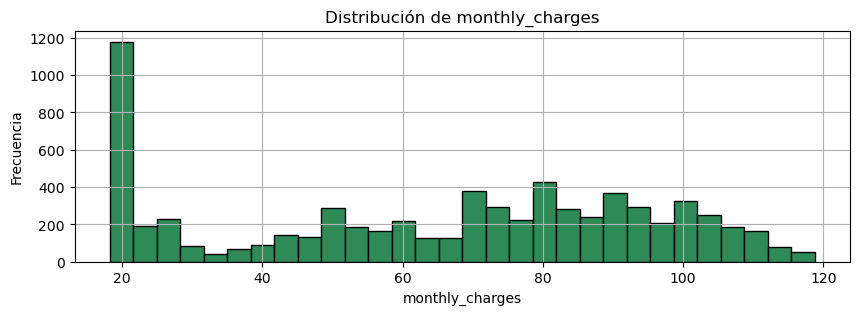

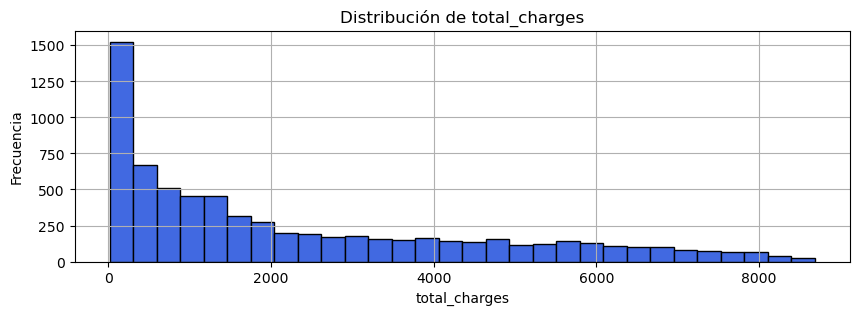

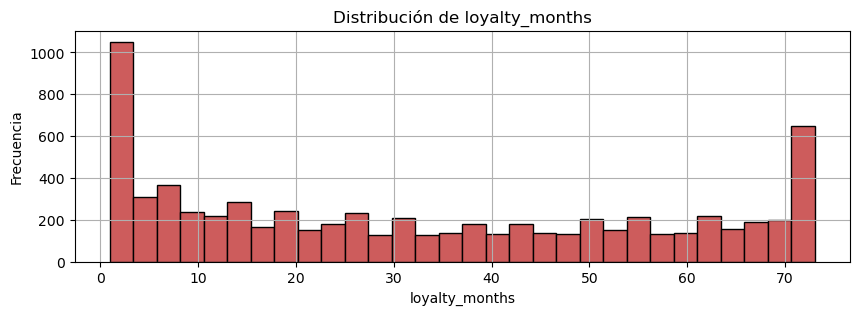

Distribución de payment_method:
electronic_check             33.631968
mailed_check                 22.810011
bank_transfer_(automatic)    21.928328
credit_card_(automatic)      21.629693
Name: payment_method, dtype: float64
Distribución de type:
monthly     55.105233
two_year    23.961889
yearly      20.932878
Name: type, dtype: float64
Distribución de internet_service:
fiber_optic            44.027304
dsl                    34.357224
no_internet_service    21.615472
Name: internet_service, dtype: float64
Distribución de paperless_billing:
1    59.2719
0    40.7281
Name: paperless_billing, dtype: float64
Distribución de gender:
1    50.469283
0    49.530717
Name: gender, dtype: float64
Distribución de senior_citizen:
0    83.759954
1    16.240046
Name: senior_citizen, dtype: float64
Distribución de partner:
0    51.749147
1    48.250853
Name: partner, dtype: float64
Distribución de dependents:
0    70.150739
1    29.849261
Name: dependents, dtype: float64
Distribución de online_securi

In [26]:
# Análisis de las características numéricas, categóricas y binarias
cols_num = ['monthly_charges', 'total_charges', 'loyalty_months']
cols_cat = ['payment_method', 'type', 'internet_service']
cols_binarias = ['paperless_billing', 'gender', 'senior_citizen',
                 'partner', 'dependents', 'online_security', 'online_backup',
                 'device_protection', 'tech_support', 'streaming_tv',
                 'streaming_movies', 'multiple_lines']


def analizar_variables(df, cols_num, cols_cat, cols_binarias):

    # Variables numéricas
    colors = ['seagreen', 'royalblue', 'indianred']
    counter = 0

    for col in cols_num:
        plt.figure(figsize=(10, 3))
        df[col].hist(bins=30, color=colors[counter %
                     len(colors)], edgecolor='black')
        plt.title(f'Distribución de {col}')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.show()
        counter += 1

    # Variables categóricas
    for col in cols_cat:
        print(f"Distribución de {col}:")
        print(df[col].value_counts(normalize=True) * 100)
        balance = df[col].value_counts(normalize=True)
        print('==========================')

    # Variables binarias
    for col in cols_binarias:
        print(f"Distribución de {col}:")
        print(df[col].value_counts(normalize=True) * 100)
        balance = df[col].value_counts(normalize=True)
        print('==========================')


analizar_variables(df_final, cols_num, cols_cat, cols_binarias)

##### Outliers características

In [27]:
def analizar_outliers_iqr(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[columna] < lower_bound) | (df[columna] > upper_bound)]

    print(f"=== ANÁLISIS DE OUTLIERS: {columna} ===")
    print(f"Q1: {Q1:.2f}")
    print(f"Q3: {Q3:.2f}")
    print(f"IQR: {IQR:.2f}")
    print(f"Límite inferior: {lower_bound:.2f}")
    print(f"Límite superior: {upper_bound:.2f}")
    print(f"Número de outliers: {len(outliers)}")
    print(f"Porcentaje de outliers: {len(outliers)/len(df)*100:.2f}%")

    return outliers


# Aplicar a tus variables
for col in cols_num:
    outliers = analizar_outliers_iqr(df_final, col)
    print("\n" + "="*50 + "\n")

=== ANÁLISIS DE OUTLIERS: monthly_charges ===
Q1: 35.59
Q3: 89.86
IQR: 54.27
Límite inferior: -45.82
Límite superior: 171.27
Número de outliers: 0
Porcentaje de outliers: 0.00%


=== ANÁLISIS DE OUTLIERS: total_charges ===
Q1: 401.45
Q3: 3794.74
IQR: 3393.29
Límite inferior: -4688.48
Límite superior: 8884.67
Número de outliers: 0
Porcentaje de outliers: 0.00%


=== ANÁLISIS DE OUTLIERS: loyalty_months ===
Q1: 9.00
Q3: 55.00
IQR: 46.00
Límite inferior: -60.00
Límite superior: 124.00
Número de outliers: 0
Porcentaje de outliers: 0.00%




Conclusión  
* No existen outliers en las características.

#### Análisis variable objetivo

##### Correlación variable objetivo con características

In [28]:
# Averiguamos correlación de las características con la variable objetivo
df_final.corr()['cancelation'].sort_values(ascending=False)

cancelation          1.000000
monthly_charges      0.192858
paperless_billing    0.191454
senior_citizen       0.150541
streaming_tv         0.063254
streaming_movies     0.060860
multiple_lines       0.040033
gender              -0.008545
device_protection   -0.066193
online_backup       -0.082307
partner             -0.149982
dependents          -0.163128
tech_support        -0.164716
online_security     -0.171270
total_charges       -0.199484
loyalty_months      -0.353766
Name: cancelation, dtype: float64

Conclusión  
* Correlacion más alta, la columna **'loyalty_months'**, existe una correlación importante, entre más tiempo el cliente ha permanecido con el servicio menos probabilidad existe de que el cliente cancele.


##### Correlación variable objetivo con variables categóricas

In [29]:
# Para cada variable categórica
for col in cols_cat:
    print(f"\n=== {col} ===")
    print(df_final.groupby(col)['cancelation'].value_counts(normalize=True))
    print('\n====================================================')


=== payment_method ===
payment_method             cancelation
bank_transfer_(automatic)  0              0.832685
                           1              0.167315
credit_card_(automatic)    0              0.847469
                           1              0.152531
electronic_check           0              0.547146
                           1              0.452854
mailed_check               0              0.807980
                           1              0.192020
Name: cancelation, dtype: float64


=== type ===
type      cancelation
monthly   0              0.572903
          1              0.427097
two_year  0              0.971513
          1              0.028487
yearly    0              0.887228
          1              0.112772
Name: cancelation, dtype: float64


=== internet_service ===
internet_service     cancelation
dsl                  0              0.810017
                     1              0.189983
fiber_optic          0              0.581072
                     1   

Conclusión  
* Las variables con alta cancelación son los siguientes:
    1- Clientes que pagan con cheque electrónico (electronic_check) con **45.28%**.  
    2- Clientes con contratos mensuales (monthly) con **42.70%**.  
    3- Clientes con servicio de internet conectados mediante fibra óptica (fiber_optic) con **41.89%**.  

##### Distribución y balance de clases variable objetivo


Distribución de cancelación:
Total de registros: 7032
0    5163
1    1869
Name: cancelation, dtype: int64

Porcentajes:
0    73.421502
1    26.578498
Name: cancelation, dtype: float64

⚠️ Variable objetivo DESBALANCEADA


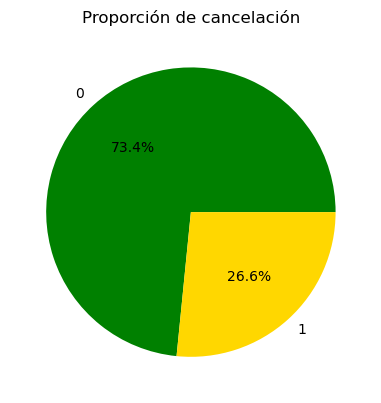

In [30]:
# Balance de clases en el target
def analizar_target(df, target_col='cancelation'):
    print(f"\nDistribución de cancelación:")
    print(f"Total de registros: {len(df)}")
    print(df[target_col].value_counts())
    print(f"\nPorcentajes:")
    print(df[target_col].value_counts(normalize=True) * 100)

    # Verificar si está balanceado
    balance = df[target_col].value_counts(normalize=True)
    if balance.min() < 0.3:
        print("\n⚠️ Variable objetivo DESBALANCEADA")

    else:
        print("\n✅ Variable objetivo relativamente BALANCEADA")

    # Visualización
    plt.figure(figsize=(8, 4))

    # Gráfico de pastel
    plt.subplot(1, 2, 2)
    df[target_col].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=[
        'green', 'gold'])  # Corregido: value_counts()
    plt.title(f'Proporción de cancelación')
    plt.ylabel('')  # Quita el label del eje Y en el pie chart

    plt.tight_layout()
    plt.show()


# Ejecución de la función
analizar_target(df_final, 'cancelation')

Conclusión  
* **Sí** existe desbalance de clases, será necesario tratarlo.

#### Hipótesis

##### Hipótesis 1: "Entre más alta sea la lealtad, menor sera la tasa de cancelación"

In [31]:
# hipótesis nula:
h0 = 'no existe relación entre los meses de lealtad y la tasa de cancelación.'
# h1 hipótesis alternativa:
h1 = 'existe una relación negativa entre los meses de lealtad y la tasa de cancelación (a mayor lealtad, menor cancelación).'


# Tomamos las muestras de lealtad de 100 usuarios
df_loyalty_one_year = df_final.query("loyalty_months < 12").sample(100)
df_loyalty_two_years = df_final.query(
    "loyalty_months >= 12 and loyalty_months < 24").sample(100)
df_loyalty_more_than_two_years = df_final.query(
    "loyalty_months >= 24").sample(100)

# Porcentaje de cancelación en cada grupo
rate_1_year = df_loyalty_one_year['cancelation'].mean() * 100
rate_2_years = df_loyalty_two_years['cancelation'].mean() * 100
rate_more_2_years = df_loyalty_more_than_two_years['cancelation'].mean() * 100

print(f"Cancelación < 12 meses: {rate_1_year:.1f}%")
print(f"Cancelación 12-24 meses: {rate_2_years:.1f}%")
print(f"Cancelación > 24 meses: {rate_more_2_years:.1f}%")

if rate_1_year > rate_2_years and rate_2_years > rate_more_2_years:
    print(f"\nRechazamos la hipótesis nula, {h1}")
else:
    print(f"\nNo podemos rechazar la hipótesis nula, {h0} ")

Cancelación < 12 meses: 52.0%
Cancelación 12-24 meses: 30.0%
Cancelación > 24 meses: 15.0%

Rechazamos la hipótesis nula, existe una relación negativa entre los meses de lealtad y la tasa de cancelación (a mayor lealtad, menor cancelación).


##### Hipótesis 2: "Las mujeres solteras con algún dependiente y las mujeres con pareja y sin dependientes tienen la misma tasa de cancelación"

In [32]:
# Prueba estadística
import scipy.stats as st

# hipótesis nula:
h0 = 'las mujeres solteras con dependientes y las mujeres casadas sin dependientes tienen una tasa de cancelación estadísticamente igual.'
# h1 hipótesis alternativa:
h1 = 'las mujeres solteras con dependientes y las mujeres casadas sin dependientes tienen una tasa de cancelación significativamente diferente.'
# Nivel de confianza: 95%
alpha = 0.05


# Tomamos las muestras de 100 usuarios mujeres de cada grupo
sample_1 = df_final.query(
    "gender == 0 and partner == 0 and dependents == 1").sample(100)
sample_2 = df_final.query(
    "gender == 0 and partner == 1 and dependents == 0").sample(100)

# Extraemos las columnas de cancelación
sample_1_cancelation = sample_1['cancelation']
sample_2_cancelation = sample_2['cancelation']

# Prueba de Levene para igualdad de varianzas
statistic, pvalue = st.levene(sample_1_cancelation, sample_2_cancelation)
results = st.ttest_ind(sample_1_cancelation,
                       sample_2_cancelation, equal_var=statistic)

print('statistic:', statistic)
print('valor p: ', results.pvalue)

if results.pvalue < alpha:
    print(f"Rechazamos la hipótesis nula, {h1}")
else:
    print(f"No podemos rechazar la hipótesis nula, {h0} ")

statistic: 0.6535516239767633
valor p:  0.4198159983689028
No podemos rechazar la hipótesis nula, las mujeres solteras con dependientes y las mujeres casadas sin dependientes tienen una tasa de cancelación estadísticamente igual. 


## Preparación y entrenamiento de los modelos de clasificación

### Codificación, segmentación y estandarización de datos

In [33]:
# Eliminamos columnas innecesarias para el modelado
df = df_final.drop(['customer_id', 'begin_date'], axis=1)

# Misma aleatoriedad
random = 23451

# Creación de función 'upsample' para desequilibrio de clases


def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=random)

    return features_upsampled, target_upsampled

#### Datos sin One-Hot encoding (LightGBM)

In [34]:
# Segmentamos los datos en entrenamiento, validación y prueba
df_train_lgbm, df_valid_lgbm = train_test_split(
    df, test_size=0.40, random_state=random)
df_valid_lgbm, df_test_lgbm = train_test_split(
    df_valid_lgbm, test_size=0.50, random_state=random)

# Aplicamos sobremuestreo solo en el set de entrenamiento
features_train_lgbm = df_train_lgbm.drop(['cancelation'], axis=1)
target_train_lgbm = df_train_lgbm['cancelation']
features_valid_lgbm = df_valid_lgbm.drop(['cancelation'], axis=1)
target_valid_lgbm = df_valid_lgbm['cancelation']
features_test_lgbm = df_test_lgbm.drop(['cancelation'], axis=1)
target_test_lgbm = df_test_lgbm['cancelation']

#### Datos con One-Hot encoding

In [35]:
# Codificación de datos
df_ohe = pd.get_dummies(df, drop_first=True)

# Segmentamos los datos en entrenamiento, validación y prueba
df_train, df_valid = train_test_split(
    df_ohe, test_size=0.40, random_state=random)
df_valid, df_test = train_test_split(
    df_valid, test_size=0.50, random_state=random)

# Aplicamos sobremuestreo solo en el set de entrenamiento
features_train = df_train.drop(['cancelation'], axis=1)
target_train = df_train['cancelation']
features_valid = df_valid.drop(['cancelation'], axis=1)
target_valid = df_valid['cancelation']
features_test = df_test.drop(['cancelation'], axis=1)
target_test = df_test['cancelation']

### Entrenamiento de modelos

#### Modelo Dummy

In [36]:
# Creamos conjunto upsampled
features_upsampled, target_upsampled = upsample(
    features_train, target_train, repeat=3)

model_dummy = DummyClassifier(strategy='most_frequent')
model_dummy.fit(features_upsampled, target_upsampled)
dummy_pred = model_dummy.predict(features_test)

# Calcular métricas
dummy_f1 = f1_score(target_test, dummy_pred)
dummy_accuracy = accuracy_score(target_test, dummy_pred)
dummy_auc_roc = roc_auc_score(target_test, dummy_pred)

print(f"Dummy F1: {dummy_f1:.4f}")
print(f"Dummy Accuracy: {dummy_accuracy:.4f}")
print(f"Dummy AUC-ROC: {dummy_auc_roc:.4f}")

Dummy F1: 0.4173
Dummy Accuracy: 0.2637
Dummy AUC-ROC: 0.5000


#### Modelo Regresión logística

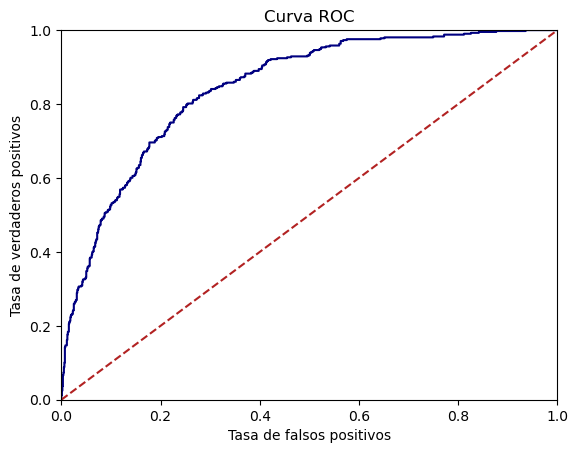

3
El f1_score del modelo en el conjunto de validación es: 0.6532
El score de la curva ROC de este modelo en el conjunto de validación es: 0.8447



In [37]:
# Estandarización de datos para regresión logística
features_train_sc = features_train.copy()
features_valid_sc = features_valid.copy()
features_test_sc = features_test.copy()

numeric = ['loyalty_months', 'monthly_charges', 'total_charges']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train_sc[numeric] = scaler.transform(features_train_sc[numeric])
features_valid_sc[numeric] = scaler.transform(features_valid_sc[numeric])
features_test_sc[numeric] = scaler.transform(features_test_sc[numeric])

# Buscamos el mejor 'repeat' para la regresión logística
repeat_values_regression = [1, 2, 3, 4, 5, 6]
best_f1_regression = 0
best_repeat_regression = 1

for repeat_regression in repeat_values_regression:
    features_up, target_up = upsample(
        features_train_sc, target_train, repeat_regression)
    model = LogisticRegression(random_state=random, solver='liblinear')
    model.fit(features_up, target_up)
    predicted = model.predict(features_valid_sc)
    f1 = f1_score(target_valid, predicted)
    if f1 > best_f1_regression:
        best_f1_regression = f1
        best_repeat_regression = repeat_regression

# Creamos conjunto 'upsampled_regression' con el mejor 'repeat'
features_upsampled_regression, target_upsampled_regression = upsample(
    features_train_sc, target_train, best_repeat_regression)

# Calculamos el f1_score
model = LogisticRegression(random_state=random, solver='liblinear')
model.fit(features_upsampled_regression, target_upsampled_regression)
predicted_valid_regression = model.predict(features_valid_sc)
f1_score_regression = f1_score(target_valid, predicted_valid_regression)

# Calculamos el roc_auc_score
probabilities_valid_regression = model.predict_proba(features_valid_sc)
probabilities_one_valid_regression = probabilities_valid_regression[:, 1]
auc_roc_regression = roc_auc_score(
    target_valid, probabilities_one_valid_regression)

# Graficamos el comportamiento de la curva ROC
fpr, tpr, thresholds = roc_curve(
    target_valid, probabilities_one_valid_regression)
plt.figure()
plt.plot(fpr, tpr, color='navy')
plt.plot([0, 1], [0, 1], linestyle='--', color='firebrick')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

f1_regression = f1_score_regression.round(4)
auc_roc_regression = auc_roc_regression.round(4)

print(best_repeat_regression)
print("El f1_score del modelo en el conjunto de validación es:", f1_regression)
print("El score de la curva ROC de este modelo en el conjunto de validación es:",
      auc_roc_regression)
print()

#### Modelo Árbol de decisión

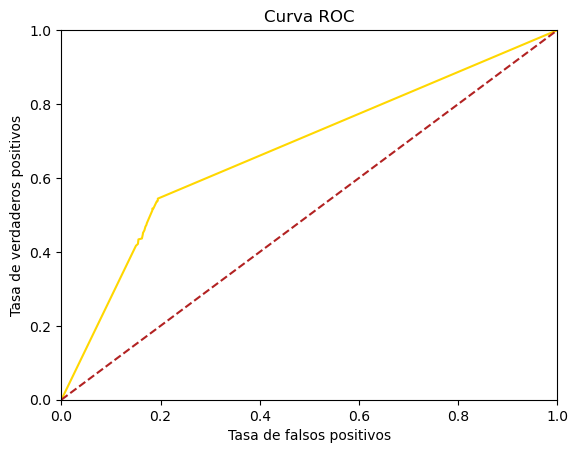

El f1_score del modelo en el conjunto de validación fue: 0.6136 con una (max_depth = 9).
El score de la curva ROC de este modelo en el conjunto de validación es: 0.6743



In [38]:
# Buscamos el mejor 'repeat' para el árbol de decisión
repeat_values_tree = [5, 6, 7, 8, 9, 10]
best_f1_tree = 0
best_repeat_tree = 1

for repeat_tree in repeat_values_tree:
    features_up, target_up = upsample(
        features_train, target_train, repeat_tree)
    model = DecisionTreeClassifier(random_state=random)
    model.fit(features_up, target_up)
    predicted = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted)
    if f1 > best_f1_tree:
        best_f1_tree = f1
        best_repeat_tree = repeat_tree

# Creamos conjunto 'upsampled_tree' con el mejor 'repeat'
features_upsampled_tree, target_upsampled_tree = upsample(
    features_train, target_train, best_repeat_tree)

# Entrenamos modelo 'upsample'
best_score_tree = 0
best_depth = 0
for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=random, max_depth=depth)
    model.fit(features_upsampled_tree, target_upsampled_tree)
    predicted_valid = model.predict(features_valid)
    f1_score_tree = f1_score(target_valid, predicted_valid)
    if f1_score_tree > best_score_tree:
        best_score_tree = f1_score_tree
        best_depth = depth

# Calculamos el roc_auc_score
probabilities_valid_tree = model.predict_proba(features_valid)
probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree)

# Graficamos el comportamiento de la curva ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_tree)
plt.figure()
plt.plot(fpr, tpr, color='gold')
plt.plot([0, 1], [0, 1], linestyle='--', color='firebrick')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

f1_tree = best_score_tree.round(4)
auc_roc_tree = auc_roc_tree.round(4)

print("El f1_score del modelo en el conjunto de validación fue: {} con una (max_depth = {}).".format(
    f1_tree, best_depth))
print("El score de la curva ROC de este modelo en el conjunto de validación es:", auc_roc_tree)
print()

#### Modelo Bosque aleatorio

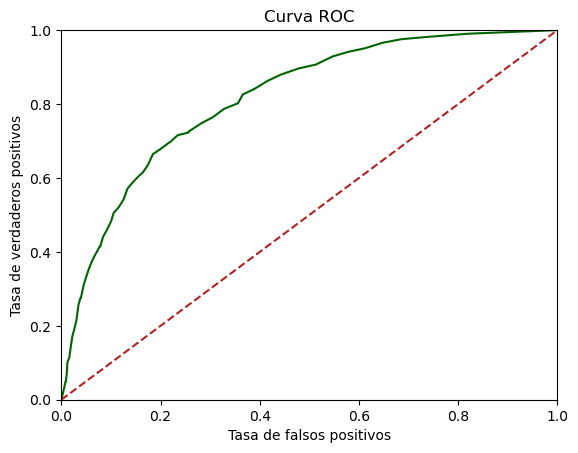

El f1_score del modelo en el conjunto de validación fue: 0.6101 con una (n_estimators = 31).
El score de la curva ROC de este modelo en el conjunto de validación es: 0.8158



In [39]:
# Buscamos el mejor 'repeat' para el bosque aleatorio
repeat_values_forest = [8, 9, 10, 11, 12, 13, 14, 15, 20]
best_f1_forest = 0
best_repeat_forest = 1

for repeat_forest in repeat_values_forest:
    features_up, target_up = upsample(
        features_train, target_train, repeat_forest)
    model = RandomForestClassifier(random_state=random)
    model.fit(features_up, target_up)
    predicted = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted)
    if f1 > best_f1_forest:
        best_f1_forest = f1
        best_repeat_forest = repeat_forest

# Creamos conjunto 'upsampled_forest' con el mejor 'repeat'
features_upsampled_forest, target_upsampled_forest = upsample(
    features_train, target_train, best_repeat_forest)

# Localizamos la mejor estimación con el mejor f1_score para nuestro bosque
best_score_forest = 0
best_est = 0
for est in range(1, 50):
    model = RandomForestClassifier(
        random_state=random, n_estimators=est, n_jobs=-1)
    model.fit(features_upsampled_forest, target_upsampled_forest)
    predicted_valid_forest = model.predict(features_valid)
    f1_score_forest = f1_score(target_valid, predicted_valid_forest)
    if f1_score_forest > best_score_forest:
        best_score_forest = f1_score_forest
        best_est = est

# Calculamos el roc_auc_score
probabilities_valid_forest = model.predict_proba(features_valid)
probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
auc_roc_forest = roc_auc_score(target_valid, probabilities_one_valid_forest)

# Graficamos el comportamiento de la curva ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_forest)
plt.figure()
plt.plot(fpr, tpr, color='darkgreen')
plt.plot([0, 1], [0, 1], linestyle='--', color='firebrick')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

f1_forest = best_score_forest.round(4)
auc_roc_forest = auc_roc_forest.round(4)


print("El f1_score del modelo en el conjunto de validación fue: {} con una (n_estimators = {}).".format(
    f1_forest, best_est))
print("El score de la curva ROC de este modelo en el conjunto de validación es:", auc_roc_forest)
print()

#### Modelo Light GBM

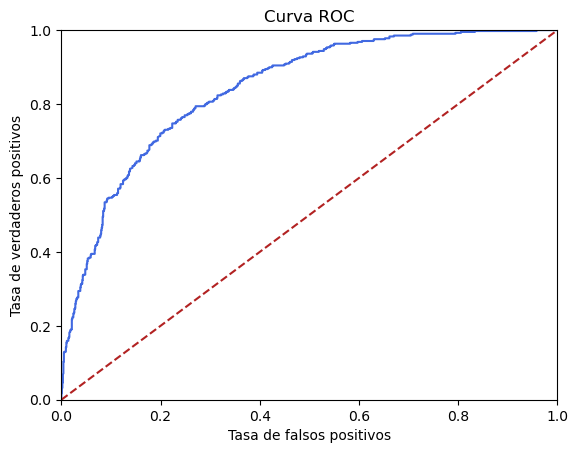

2
137
El f1_score del modelo en el conjunto de validación fue: 0.6696 con una (n_estimators = 137).
El score de la curva ROC de este modelo en el conjunto de validación es: 0.8414



In [40]:
# Indicamos las categorías para LightGBM
categorical_features = ['payment_method', 'type', 'internet_service']

# Buscamos el mejor 'repeat' para el bosque aleatorio
repeat_values_lgbm = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
best_f1_lgbm = 0
best_repeat_lgbm = 1

for repeat_lgbm in repeat_values_lgbm:
    features_up, target_up = upsample(
        features_train_lgbm, target_train_lgbm, repeat_lgbm)
    model_lgbm = lgb.LGBMClassifier(random_state=random,
                                    n_estimators=est,
                                    num_leaves=10,
                                    learning_rate=0.05,
                                    max_depth=5,
                                    objective='binary',
                                    metric='auc',
                                    verbose=-1,
                                    n_jobs=-1)
    model_lgbm.fit(features_up, target_up,
                   categorical_feature=categorical_features)
    predicted = model_lgbm.predict(features_valid_lgbm)
    f1 = f1_score(target_valid_lgbm, predicted)
    if f1 > best_f1_lgbm:
        best_f1_lgbm = f1
        best_repeat_lgbm = repeat_lgbm

# Creamos conjunto 'upsampled_lgbm' con el mejor 'repeat'
features_upsampled_lgbm, target_upsampled_lgbm = upsample(
    features_train_lgbm, target_train_lgbm, best_repeat_lgbm)

# Localizamos la mejor estimación con el mejor f1_score para nuestro bosque
best_score_lgbm = 0
best_est_lgbm = 0
for est in range(1, 300):
    model_lgbm = lgb.LGBMClassifier(random_state=random,
                                    n_estimators=est,
                                    learning_rate=0.015,
                                    max_depth=5,
                                    objective='binary',
                                    metric='auc',
                                    verbose=-1,
                                    n_jobs=-1)
    model_lgbm.fit(features_upsampled_lgbm, target_upsampled_lgbm,
                   categorical_feature=categorical_features)
    predicted_valid_lgbm = model_lgbm.predict(features_valid_lgbm)
    f1_score_lgbm = f1_score(target_valid_lgbm, predicted_valid_lgbm)
    if f1_score_lgbm > best_score_lgbm:
        best_score_lgbm = f1_score_lgbm
        best_est_lgbm = est

# Calculamos el roc_auc_score
probabilities_valid_lgbm = model_lgbm.predict_proba(features_valid_lgbm)
probabilities_one_valid_lgbm = probabilities_valid_lgbm[:, 1]
auc_roc_lgbm = roc_auc_score(target_valid_lgbm, probabilities_one_valid_lgbm)

# Graficamos el comportamiento de la curva ROC
fpr, tpr, thresholds = roc_curve(
    target_valid_lgbm, probabilities_one_valid_lgbm)
plt.figure()
plt.plot(fpr, tpr, color='royalblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='firebrick')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

f1_lgbm = best_score_lgbm.round(4)
auc_roc_lgbm = auc_roc_lgbm.round(4)


print(best_repeat_lgbm)
print(best_est_lgbm)
print("El f1_score del modelo en el conjunto de validación fue: {} con una (n_estimators = {}).".format(
    f1_lgbm, best_est_lgbm))
print("El score de la curva ROC de este modelo en el conjunto de validación es:", auc_roc_lgbm)
print()

## Probar modelos y elección del más eficiente

#### Prueba de Regresión logística

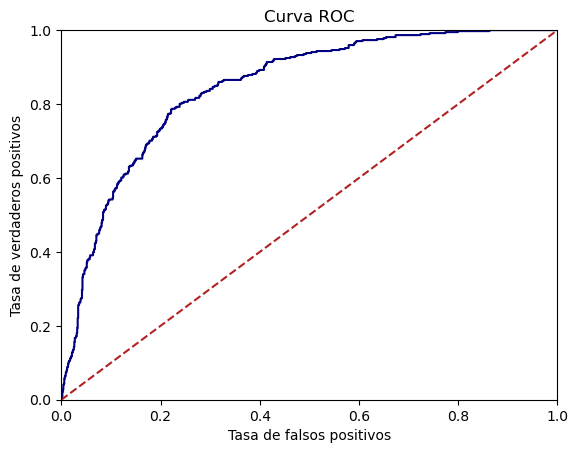


Random_state= 23451
Mejor "repeat": 8
El f1_score del modelo en el conjunto de prueba final en el modelo de regresión lineal es: 0.5570630486831605
La precisión del modelo en el conjunto de prueba final en el modelo de regresión lineal es: 0.605543710021322
El score de la curva ROC de este modelo en el conjunto de prueba final en el modelo de regresión lineal  es: 0.8461413377181571



In [41]:
# Parámetros mejor modelo
best_repeat_final_regression = 8

# Enfoque de sobremuestreo
features_upsampled_final_regression, target_upsampled_final_regression = upsample(
    features_train_sc, target_train, best_repeat_final_regression)

# Ejecución mejor modelo
best_model_regressor = LogisticRegression(
    random_state=random, solver='liblinear')
best_model_regressor.fit(
    features_upsampled_final_regression, target_upsampled_final_regression)
predicted_test = best_model_regressor.predict(features_test_sc)
f1_score_final_regression = f1_score(target_test, predicted_test)
accuracy_regression = accuracy_score(target_test, predicted_test)

# Calculamos el roc_auc_score
probabilities_test_final = best_model_regressor.predict_proba(features_test_sc)
probabilities_one_test_final = probabilities_test_final[:, 1]
auc_roc_final_regression = roc_auc_score(
    target_test, probabilities_one_test_final)

# Graficamos el comportamiento de la curva ROC
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test_final)
plt.figure()
plt.plot(fpr, tpr, color='navy')
plt.plot([0, 1], [0, 1], linestyle='--', color='firebrick')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()


print()
print(f'Random_state= {random}')
print(f'Mejor "repeat": {best_repeat_final_regression}')
print("El f1_score del modelo en el conjunto de prueba final en el modelo de regresión lineal es: {}".format(
    f1_score_final_regression))
print("La precisión del modelo en el conjunto de prueba final en el modelo de regresión lineal es: {}".format(
    accuracy_regression))
print("El score de la curva ROC de este modelo en el conjunto de prueba final en el modelo de regresión lineal  es:", auc_roc_final_regression)
print()

#### Prueba de Light GBM

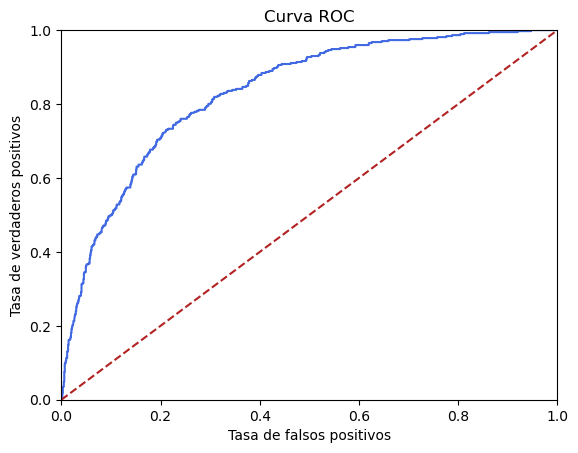


Random_state= 23451
Mejor "repeat": 3
El f1_score del modelo en el conjunto de prueba final en el modelo light GBM es: 0.613588110403397 con una (n_estimators = 170).
La precisión del modelo en el conjunto de prueba final en el modelo light GBM es: 0.7412935323383084
El score de la curva ROC de este modelo en el conjunto de prueba final en el modelo light GBM es: 0.832069747837942



In [42]:
# Mejores parámetros modelo LightGBM
best_repeat_final = 3
best_est_final = 170

# Enfoque de sobremuestreo
features_upsampled_final_lgbm, target_upsampled_final_lgbm = upsample(
    features_train_lgbm, target_train_lgbm, best_repeat_final)

# Ejecución mejor modelo
best_model_lgbm = lgb.LGBMClassifier(random_state=random,
                                     n_estimators=est,
                                     learning_rate=0.015,
                                     max_depth=5,
                                     objective='binary',
                                     metric='auc',
                                     verbose=-1,
                                     n_jobs=-1)
best_model_lgbm.fit(features_upsampled_final_lgbm, target_upsampled_final_lgbm)
predicted_test_lgbm = best_model_lgbm.predict(features_test_lgbm)
f1_score_final_lgbm = f1_score(target_test_lgbm, predicted_test_lgbm)
accuracy_lgbm = accuracy_score(target_test_lgbm, predicted_test_lgbm)

# Calculamos el roc_auc_score
probabilities_test_final = best_model_lgbm.predict_proba(features_test_lgbm)
probabilities_one_test_final = probabilities_test_final[:, 1]
auc_roc_final_lgbm = roc_auc_score(
    target_test_lgbm, probabilities_one_test_final)

# Graficamos el comportamiento de la curva ROC
fpr, tpr, thresholds = roc_curve(
    target_test_lgbm, probabilities_one_test_final)
plt.figure()
plt.plot(fpr, tpr, color='royalblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='firebrick')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

print()
print(f'Random_state= {random}')
print(f'Mejor "repeat": {best_repeat_final}')
print("El f1_score del modelo en el conjunto de prueba final en el modelo light GBM es: {} con una (n_estimators = {}).".format(
    f1_score_final_lgbm, best_est_final))
print("La precisión del modelo en el conjunto de prueba final en el modelo light GBM es: {}".format(accuracy_lgbm))
print("El score de la curva ROC de este modelo en el conjunto de prueba final en el modelo light GBM es:", auc_roc_final_lgbm)
print()

## Resultados finales (dataset de prueba)

In [43]:
print('                        F1         Accuracy      AUC     ')
print(f'Regresión lineal:     {(f1_score_final_regression*100).round(2)}%        {(accuracy_regression*100).round(2)}%      {(auc_roc_final_regression*100).round(2)}%')
print(
    f'Light GBM:            {(f1_score_final_lgbm*100).round(2)}%        {(accuracy_lgbm*100).round(2)}%      {(auc_roc_final_lgbm*100).round(2)}% ')

                        F1         Accuracy      AUC     
Regresión lineal:     55.71%        60.55%      84.61%
Light GBM:            61.36%        74.13%      83.21% 


### Conclusiones
---
**ELección de modelo**
- Elegiremos el modelo de **Light GBM** por su puntuación en 'Accuracy' y 'F1' más alto que la regresión lineal, aunque la la métrica 'AUC-ROC' es levemente inferior por solo poco más de 1 punto pocentual.  


**Explicación de métricas**
- F1 score: El modelo tiene un balance entre precisión y recall con el **61.5%** de efectividad balanceada.  
- Accuracy: Con una puntuación de **74%** el modelo nos dice que acierta en la respuesta correcta 74 veces de cada 100.
- Auc-roc: Se logro una puntuación de **83%**, lo que significa que el modelo tiene 83.0% de probabilidad de distinguir correctamente entre clases.  


**General**
- Logramos construir un modelo que nos pueda proporcionar que clientes podrían cancelar sus servicios con una precisión del 74%.


In [ ]:
# Versiones de librerías
import sys
import sklearn
import matplotlib as plt
print("Versiones de las librerías:")
print(f"python=={sys.version}")
print(f"pandas=={pd.__version__}")
print(f"numpy=={np.__version__}")
print(f"matplotlib=={plt.__version__}")
print(f"seaborn=={sns.__version__}")
print(f"sklearn=={sklearn.__version__}")
print(f"lightgbm=={lgb.__version__}")
print(f"scipy=={scipy.__version__}")

Versiones de las librerías:
python==3.8.20 (default, Oct  3 2024, 15:19:54) [MSC v.1929 64 bit (AMD64)]
pandas==1.2.4
numpy==1.23.5
matplotlib==3.7.2
seaborn==0.13.2
sklearn==1.3.2
lightgbm==4.4.0
scipy==1.10.1
